<a href="https://colab.research.google.com/github/kprains/MM_2024/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ Практика 3: Подбор признаков и валидация моделей

## **Цель занятия:**
Изучить методы поиска значимых признаков в данных. На практике мы проведем анализ целевой переменной **Y**, применим методы для поиска значимых признаков, обучим линейную модель, проанализируем результат и оценим валидность модели.

## **Задание состоит из следующих частей:**
1. Обработка выбросов;
1. Поиск значимых признаков с использованием библиотеки **sklearn**.
2. Обучение логистической регресси модели и оценка ее точности.
6. Кросс-валидация с использованием разных методов (K-fold, ShuffleSplit, test-train-validation)

## 1: Загрузка библиотек и предобратка данных

In [1]:
!pip install pandas scikit-learn seaborn scipy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel

In [3]:
# Загрузка набора данных
df = pd.read_csv('/content/income.csv')

In [49]:
df

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K,workhorse
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,1
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,1
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0,1
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0,1
32557,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1,1
32558,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0,1
32559,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0,0


In [50]:
df['workhorse'] = np.where(df['hours-per-week'] >= 40, 1, 0)
df.workhorse = df.workhorse.astype('category')
df['race'] = df['race'].astype('category')

In [51]:
Y = df['workhorse'] # выбираем целевую переменную (категориальную)
X = df.drop('workhorse', axis=1) # переменные для проверки влияния

# В моем случае я дропаю базовую переменную, а не только. Y
X = X.drop('hours-per-week', axis=1)

In [52]:
df.drop('hours-per-week', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             32561 non-null  int64   
 1   workclass       30725 non-null  object  
 2   education       32561 non-null  object  
 3   education-num   32561 non-null  int64   
 4   marital-status  32561 non-null  object  
 5   occupation      30718 non-null  object  
 6   relationship    32561 non-null  object  
 7   race            32561 non-null  category
 8   sex             32561 non-null  object  
 9   capital-gain    32561 non-null  int64   
 10  capital-loss    32561 non-null  int64   
 11  native-country  31978 non-null  object  
 12  income >50K     32561 non-null  int64   
 13  workhorse       32561 non-null  category
dtypes: category(2), int64(5), object(7)
memory usage: 3.0+ MB


In [53]:
df

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K,workhorse
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,1
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,1
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0,1
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0,0
32557,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1,1
32558,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0,1
32559,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0,0


## 2: масштабирование признаков

In [55]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             32561 non-null  int64   
 1   workclass       30725 non-null  object  
 2   education       32561 non-null  object  
 3   education-num   32561 non-null  int64   
 4   marital-status  32561 non-null  object  
 5   occupation      30718 non-null  object  
 6   relationship    32561 non-null  object  
 7   race            32561 non-null  category
 8   sex             32561 non-null  object  
 9   capital-gain    32561 non-null  int64   
 10  capital-loss    32561 non-null  int64   
 11  native-country  31978 non-null  object  
 12  income >50K     32561 non-null  int64   
dtypes: category(1), int64(5), object(7)
memory usage: 3.0+ MB


In [56]:
# Создаем копию данных
X_processed = X.copy()

category_columns: list[str] = X_processed.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X_processed = pd.get_dummies(X_processed, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.


In [57]:
X_processed

,age,workclass,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,native-country,income >50K,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,United-States,0,False,False,False,True
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,United-States,0,False,False,False,True
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,United-States,0,False,False,False,True
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,United-States,0,False,True,False,False
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,Cuba,0,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,Female,0,0,United-States,0,False,False,False,True
32557,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,Male,0,0,United-States,1,False,False,False,True
32558,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,Female,0,0,United-States,0,False,False,False,True
32559,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,Male,0,0,United-States,0,False,False,False,True


In [58]:
# Выбираем числовые признаки
numeric_features = X_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_processed[numeric_features] = scaler.fit_transform(X_processed[numeric_features])


In [59]:
X_processed

,age,workclass,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,native-country,income >50K,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,Male,0.021740,0.0,United-States,0.0,False,False,False,True
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,Male,0.000000,0.0,United-States,0.0,False,False,False,True
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,Male,0.000000,0.0,United-States,0.0,False,False,False,True
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Male,0.000000,0.0,United-States,0.0,False,True,False,False
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Female,0.000000,0.0,Cuba,0.0,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.136986,Private,Assoc-acdm,0.733333,Married-civ-spouse,Tech-support,Wife,Female,0.000000,0.0,United-States,0.0,False,False,False,True
32557,0.315068,Private,HS-grad,0.533333,Married-civ-spouse,Machine-op-inspct,Husband,Male,0.000000,0.0,United-States,1.0,False,False,False,True
32558,0.561644,Private,HS-grad,0.533333,Widowed,Adm-clerical,Unmarried,Female,0.000000,0.0,United-States,0.0,False,False,False,True
32559,0.068493,Private,HS-grad,0.533333,Never-married,Adm-clerical,Own-child,Male,0.000000,0.0,United-States,0.0,False,False,False,True


## 3: Очистка данных и удаление выбросов

Важным шагом в машинном обучении - является очистка и удаление данных от выбросов.

### Методы обработки выбросов:

1. **Метод на основе медианы и межквартильного размаха (IQR)**:
   - **Как работает**:
     Метод основан на расчете межквартильного размаха (IQR), который вычисляется как разница между третьим (75-й перцентиль) и первым квартилем (25-й перцентиль). Данные считаются выбросами, если они выходят за пределы диапазона \([Q1 - 1.5 * IQR , Q3 + 1.5 * IQR]\).
   - **Зачем это нужно**:
     Выбросы могут серьезно искажать результаты моделей, особенно тех, которые основаны на средних значениях или предполагают нормальное распределение данных.
   - **Когда лучше использовать**:
     - Когда данные содержат **немного выбросов** и имеют **асимметричное распределение**.
     - Метод медианы и IQR более устойчив к выбросам по сравнению с методом, основанным на среднем значении, так как медиана меньше подвержена влиянию экстремальных значений.
     - Хорошо подходит для набора данных, которые не распределены нормально (например, зарплаты или цены на недвижимость).

2. **Метод на основе среднего (Mean)**:
   - **Как работает**:
     Метод использует средние значения и удаляет те признаки или записи, которые значительно отклоняются от среднего. Чаще всего это делается с помощью установления порога (например, данные, которые превышают 2 или 3 средних значения, считаются выбросами).
   - **Зачем это нужно**:
     Выбросы, сильно отличающиеся от средних значений, могут существенно влиять на такие модели, как линейная регрессия, так как среднее значение сильно чувствительно к экстремальным точкам.
   - **Когда лучше использовать**:
     - Когда данные имеют **нормальное распределение** или приближены к нормальному.
     - Подходит, если данные содержат **много выбросов**, и вам нужно жестче ограничить их влияние на модель.

### Как выбрать метод:

- **Если данные асимметричны** или распределены с "хвостами" (например, распределение доходов или цен), лучше использовать **метод на основе медианы и IQR**, так как медиана не чувствительна к выбросам и лучше описывает такие наборы данных.
  
- **Если данные нормально распределены** и важно учитывать всю выборку, даже если есть выбросы, можно использовать **метод на основе среднего**. Этот метод будет точнее отражать центр распределения в симметричных данных и позволит выявить значительные отклонения от него.

Оба метода помогают улучшить производительность моделей машинного обучения, обеспечивая более точное представление данных для анализа и обучения.

### Для начала определеим функцию обучения с оценкой качества (для простоты)

In [68]:
# from sklearn.model_selection import cross_val_score

# # Преобразование категориальных признаков
# X_processed = pd.get_dummies(X_processed, drop_first=True)

# def train_and_evaluate(X, Y):
#     # Разделение данных на обучающую и тестовую выборки
#     X_train, X_test, Y_train, Y_test = train_test_split(
#         X, Y, test_size=0.2, random_state=42, stratify=Y)

#     # Инициализация модели
#     model = LogisticRegression(max_iter=1000)

#     # Обучение модели
#     model.fit(X_train, Y_train)

#     # Предсказания на обучающей выборке
#     Y_train_pred = model.predict(X_train)
#     train_accuracy = accuracy_score(Y_train, Y_train_pred)

#     # Предсказания на тестовой выборке
#     Y_test_pred = model.predict(X_test)
#     test_accuracy = accuracy_score(Y_test, Y_test_pred)

#     # Вывод результатов
#     print(f"Точность на обучающей выборке: {train_accuracy:.4f}")
#     print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

#     # Классификационный отчет
#     print("\nКлассификационный отчет на тестовой выборке:")
#     print(classification_report(Y_test, Y_test_pred))

#     return model




# Преобразование категориальных признаков
# Преобразуем логические столбцы в целые числа
boolean_columns = X_processed.select_dtypes(include=['bool']).columns
for col in boolean_columns:
    X_processed[col] = X_processed[col].astype(int)

# Теперь применяем One-Hot Encoding к категориальным переменным
X_processed = pd.get_dummies(X_processed, drop_first=True)

def train_and_evaluate(X, Y):
    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42, stratify=Y)

    # Инициализация модели
    model = LogisticRegression(max_iter=1000)

    # Обучение модели
    model.fit(X_train, Y_train)

    # Предсказания на обучающей выборке
    Y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(Y_train, Y_train_pred)

    # Предсказания на тестовой выборке
    Y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(Y_test, Y_test_pred)

    # Вывод результатов
    print(f"Точность на обучающей выборке: {train_accuracy:.4f}")
    print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

    # Классификационный отчет
    print("\nКлассификационный отчет на тестовой выборке:")
    print(classification_report(Y_test, Y_test_pred))


In [75]:
train_and_evaluate(X_processed, Y)

Точность на обучающей выборке: 0.7879
Точность на тестовой выборке: 0.7803

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.58      0.30      0.39      1553
           1       0.81      0.93      0.87      4960

    accuracy                           0.78      6513
   macro avg       0.69      0.61      0.63      6513
weighted avg       0.75      0.78      0.75      6513



### Метод 1: удаление на основе медианы

In [70]:
# Функция для удаления выбросов на основе межквартильного размаха (1.5 IQR)
def remove_outliers_based_on_iqr(X, y, iqr_multiplier=1.5):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем первый и третий квартили для каждой числовой переменной
    Q1 = X_numeric.quantile(0.25)
    Q3 = X_numeric.quantile(0.75)

    # Вычисляем межквартильный размах (IQR)
    IQR = Q3 - Q1

    # Оставляем только те значения, которые находятся в диапазоне [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    X_filtered = X_numeric[~((X_numeric < (Q1 - iqr_multiplier * IQR)) | (X_numeric > (Q3 + iqr_multiplier * IQR))).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered


In [71]:
X_iqr, y_iqr = remove_outliers_based_on_iqr(X_processed, Y, iqr_multiplier=3)

In [72]:
X_processed.describe()

,age,education-num,capital-gain,capital-loss,income >50K,race_Asian-Pac-Islander,race_Black,race_Other,race_White,workclass_Local-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,...,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,0.295639,0.605379,0.010777,0.020042,0.240810,0.031909,0.095943,0.008323,0.854274,0.064279,...,0.001136,0.003501,0.000369,0.002457,0.001566,0.000553,0.000584,0.895857,0.002058,0.000491
std,0.186855,0.171515,0.073854,0.092507,0.427581,0.175761,0.294518,0.090851,0.352837,0.245254,...,0.033691,0.059068,0.019194,0.049507,0.039546,0.023506,0.024149,0.305451,0.045316,0.022162
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.150685,0.533333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.273973,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.424658,0.733333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [73]:
X_iqr.describe()

,age,education-num,capital-gain,capital-loss,income >50K,race_Asian-Pac-Islander,race_Black,race_Other,race_White,workclass_Local-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
count,505.000000,505.000000,505.0,505.0,505.0,505.0,505.0,505.0,505.0,505.0,...,505.0,505.0,505.0,505.0,505.0,505.0,505.0,505.0,505.0,505.0
mean,0.355351,0.523036,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
std,0.219521,0.044241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.013699,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25%,0.164384,0.533333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
50%,0.342466,0.533333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
75%,0.534247,0.533333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
max,0.890411,0.533333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [74]:
train_and_evaluate(X_iqr, y_iqr)

Точность на обучающей выборке: 0.7401
Точность на тестовой выборке: 0.8020

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       1.00      0.26      0.41        27
           1       0.79      1.00      0.88        74

    accuracy                           0.80       101
   macro avg       0.89      0.63      0.65       101
weighted avg       0.84      0.80      0.76       101



### ⏰ **Провести анализ выводов, посмотреть как измеились переменные и описать результат**
## **Сравнение результатов**
1. Точность на обучающей и тестовой выборках
* Без удаления выбросов:

Точность на обучающей выборке: 0.7879

Точность на тестовой выборке: 0.7803
* С удалением выбросов:

Точность на обучающей выборке: 0.7401

Точность на тестовой выборке: 0.8020
### **Анализ:**

1. Точность на обучающей выборке снизилась (с 0.7879 до 0.7401), что может указывать на улучшение обобщающей способности модели (model generalization) - модель стала более сдержанной и менее склонной к переобучению. Это типичное поведение, когда выбросы удаляются, так как они могут вносить шум и ухудшать способность модели обобщаться на новых данных.
2. Точность на тестовой выборке значительно возросла (с 0.7803 до 0.8020), что показывает, что модель лучше справляется с новыми данными после удаления выбросов. Это означает, что выбросы, вероятно, негативно влияли на качество предсказаний.
**Классификационный отчет**
Precision и Recall для класса 0:

Без удаления выбросов: precision 0.58 и recall 0.30
С удалением выбросов: precision 1.00 и recall 0.26
Здесь мы видим, что precision для класса 0 стал идеальным (1.00), но recall значительно упал (0.26). Это говорит о том, что модель теперь уверенно классифицирует те случаи, которые она считает классом 0, но при этом пропускает значительный процент действительных случаев этого класса. Это может также указывать на дисбаланс в данных (мало примеров класса 0 после удаления выбросов).

Precision и Recall для класса 1:

Без удаления выбросов: precision 0.81 и recall 0.93
С удалением выбросов: precision 0.79 и recall 1.00
Здесь мы видим, что precision для класса 1 немного снизился, но модель достигла идеального recall. Это говорит о том, что модель теперь находит все примеры класса 1, но также может классифицировать некоторые примеры класса 0 неверно.

##**Заключение**
Удаление выбросов на основе межквартильного размаха привело к улучшению точности на тестовой выборке, но ухудшило точность на обучающей выборке, что может указывать на то, что модель стала менее переобученной.
Важно отметить, что выборочные классы теперь стали менее сбалансированными после удаления выбросов, что могло повлиять на качество классификации.

### Метод 2: удаление на основе среднего

In [76]:
# Функция для удаления выбросов на основе среднего значения

def remove_outliers_based_on_mean(X, y, mean_multiplier=2):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем среднее значение и стандартное отклонение для каждой переменной
    mean_values = X_numeric.mean()
    std_values = X_numeric.std()

    # Устанавливаем верхний и нижний пороги на основе среднего значения и множителя стандартного отклонения
    lower_threshold = mean_values - mean_multiplier * std_values
    upper_threshold = mean_values + mean_multiplier * std_values

    # Фильтруем наблюдения, которые находятся в пределах этих порогов по всем признакам
    X_filtered = X_numeric[~((X_numeric < lower_threshold) | (X_numeric > upper_threshold)).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered

In [77]:
X_mean, y_mean = remove_outliers_based_on_mean(X_processed.copy(), Y.copy())

In [78]:
X_processed.describe()

,age,education-num,capital-gain,capital-loss,income >50K,race_Asian-Pac-Islander,race_Black,race_Other,race_White,workclass_Local-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,...,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,0.295639,0.605379,0.010777,0.020042,0.240810,0.031909,0.095943,0.008323,0.854274,0.064279,...,0.001136,0.003501,0.000369,0.002457,0.001566,0.000553,0.000584,0.895857,0.002058,0.000491
std,0.186855,0.171515,0.073854,0.092507,0.427581,0.175761,0.294518,0.090851,0.352837,0.245254,...,0.033691,0.059068,0.019194,0.049507,0.039546,0.023506,0.024149,0.305451,0.045316,0.022162
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.150685,0.533333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.273973,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.424658,0.733333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [79]:
X_mean.describe()

,age,education-num,capital-gain,capital-loss,income >50K,race_Asian-Pac-Islander,race_Black,race_Other,race_White,workclass_Local-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
count,968.000000,968.000000,968.000000,968.0,968.000000,968.0,968.0,968.0,968.0,968.0,...,968.0,968.0,968.0,968.0,968.0,968.0,968.0,968.0,968.0,968.0
mean,0.310498,0.555992,0.003466,0.0,0.147727,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
std,0.187884,0.047610,0.016023,0.0,0.355013,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.013699,0.333333,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25%,0.136986,0.533333,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
50%,0.287671,0.533333,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
75%,0.465753,0.600000,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
max,0.657534,0.600000,0.150242,0.0,1.000000,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [80]:
train_and_evaluate(X_mean, y_mean)

Точность на обучающей выборке: 0.7946
Точность на тестовой выборке: 0.7938

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.75      0.07      0.13        42
           1       0.79      0.99      0.88       152

    accuracy                           0.79       194
   macro avg       0.77      0.53      0.51       194
weighted avg       0.79      0.79      0.72       194



### ⏰ **Провести анализ выводов, посмотреть как измеились переменные и описать результат**
## **Анализ:**

1. В случае удаления выбросов на основе среднего значения точность на обучающей и тестовой выборках осталась высокой и близкой друг к другу, что свидетельствует о том, что модель хорошо обобщается. Это похоже на то, что выбросы, возможно, оказали меньшее влияние на модель, когда она использует среднее и стандартное отклонение, чем на основе IQR.
2. Как видно из результатов, модель с удалением выбросов на основе среднего может быть менее склонна к переобучению по сравнению с предыдущим методом (IQR), но это стоит проверить на выборке больше данных.

##Precision и Recall для класса 0:

* Precision: 0.75
* Recall: 0.07
* Количество примеров: 42
Здесь мы видим, что precision для класса 0 стал достаточно высоким (0.75), однако recall критически низкий (0.07). Это говорит о том, что, хотя модель уверенно классифицирует некоторые наблюдения как класс 0, она не обнаруживает большинство истинных примеров этого класса (только 7% были правильно классифицированы как класс 0).

##Precision и Recall для класса 1:

* Precision: 0.79
* Recall: 0.99
* Количество примеров: 152
Здесь recall для класса 1 практически идеальный (0.99), что говорит о том, что модель отлично справляется с выявлением наблюдений этого класса. Однако при этом precision немного выше, чем у класса 0, что показывает, что модель могла ошибочно классифицировать некоторые наблюдения класса 0.

## **Заключение**
* Удаление выбросов на основе среднего значения привело к более сбалансированным показателям точности на обучающей выборке (0.7946) и тестовой выборке (0.7938), чем при использовании метода IQR. Однако результаты классификационного отчета показывают, что класс 0 по-прежнему вызывают проблемы, поскольку recall для этого класса очень низкий.
* Метод удаления на основе среднего значения также с высоким уровнем уверенности классифицирует класс 1, демонстрируя сильные результаты, но это также может указывать на проблему дисбаланса между классами, если различные методы удаления выбросов ведут к очень различным результатам по ни одному из классов.
Метод удаления на основе среднего оставляе бльшее количество данных, чем на основе медианы.

In [81]:
# Предположим, что X_processed - это ваш начальный DataFrame
initial_data_size = len(X_processed)

# Получаем размер после удаления выбросов на основе медианы
X_iqr, y_iqr = remove_outliers_based_on_iqr(X_processed, Y)
data_size_after_median_removal = len(X_iqr)

# Получаем размер после удаления выбросов на основе среднего
X_mean, y_mean = remove_outliers_based_on_mean(X_processed, Y)
data_size_after_mean_removal = len(X_mean)

# Выводим результаты
print(f"Общее количество наблюдений до удаления выбросов: {initial_data_size}")
print(f"Количество наблюдений после удаления выбросов на основе медианы: {data_size_after_median_removal}")
print(f"Количество наблюдений после удаления выбросов на основе среднего: {data_size_after_mean_removal}")

median_removal_loss = (initial_data_size - data_size_after_median_removal) / initial_data_size * 100
mean_removal_loss = (initial_data_size - data_size_after_mean_removal) / initial_data_size * 100

print(f"Процент потерянных наблюдений после удаления выбросов на основе медианы: {median_removal_loss:.2f}%")
print(f"Процент потерянных наблюдений после удаления выбросов на основе среднего: {mean_removal_loss:.2f}%")


Общее количество наблюдений до удаления выбросов: 32561
Количество наблюдений после удаления выбросов на основе медианы: 499
Количество наблюдений после удаления выбросов на основе среднего: 968
Процент потерянных наблюдений после удаления выбросов на основе медианы: 98.47%
Процент потерянных наблюдений после удаления выбросов на основе среднего: 97.03%


## 3: Методы отбора признаков

Отбор признаков (feature selection) — важный шаг в машинном обучении, который помогает улучшить качество моделей и ускорить их работу. Цель отбора — убрать лишние или малозначимые признаки, которые не влияют на предсказания модели, либо могут ухудшить её производительность.

Зачем это нужно:
1. **Улучшение производительности модели** — избыточные признаки могут создавать шум и снижать точность.
2. **Повышение интерпретируемости** — меньший набор признаков легче анализировать и объяснять.
3. **Снижение вычислительной сложности** — меньшее количество признаков ускоряет обучение и предсказание.

В sklearn основные методы отбора признаков включают:
1. **Filter методы** — основаны на статистических тестах, например, `SelectKBest` использует критерий, чтобы выбрать признаки с наибольшим вкладом.
2. **Wrapper методы** — оценивают модели на разных подмножествах признаков, например, рекурсивное исключение признаков (`RFE`).
3. **Embedded методы** — выполняют отбор признаков во время обучения модели, например, с помощью L1-регуляризации (Lasso).

### Filter методы

Filter методы основаны на статистических свойствах данных и выбирают признаки, не учитывая алгоритм машинного обучения. Они работают как предварительный шаг перед обучением модели и быстро отбирают наиболее информативные признаки.

Преимущества:

- Быстро выполняются.
- Не зависят от модели.
- Уменьшают размерность данных до обучения.

Недостатки:

- Не учитывают взаимодействие между признаками.
- Могут упускать важные комбинации признаков.

In [184]:
from sklearn.feature_selection import SelectKBest, f_regression


In [185]:
# Применяем SelectKBest для выбора 5 лучших признаков
selector = SelectKBest(score_func=f_regression, k=13)
X_kbest = selector.fit_transform(X_processed, Y)


In [186]:
selector.scores_

array([1.78568678e+02, 3.40296010e+02, 4.73903466e+01, 5.79430163e+01,
       1.22892889e+03, 1.71774615e+00, 3.15771803e+01, 2.65858136e+00,
       1.91615912e+01, 1.45839108e+01, 4.27658728e+00, 4.85569543e+01,
       9.07348138e+01, 1.86817091e+00, 1.46361913e+01, 8.55613844e+00,
       2.70439338e+02, 4.61086131e+01, 8.38106176e+00, 9.55922522e-02,
       8.35206552e+00, 4.12092867e+00, 2.91247110e-01, 2.56567200e+01,
       1.72805709e+02, 1.89679666e+01, 3.94397427e+01, 5.43407119e+01,
       6.65046197e+00, 1.66314600e+01, 1.73190772e+02, 6.39151814e-02,
       1.53329161e+03, 2.37624610e+00, 1.27169082e+03, 1.47916700e+01,
       3.71074532e+02, 8.03475648e-01, 4.39658133e+02, 4.41290043e+02,
       1.10593352e+01, 6.84129399e+00, 1.92172521e+02, 1.26891361e+03,
       7.36150184e+01, 3.34310720e+01, 4.21533195e+01, 4.07648873e+01,
       1.42033376e+00, 1.01139923e+02, 5.65612313e-02, 5.58163004e+01,
       2.01303199e+03, 4.43534882e+01, 1.48515247e+02, 1.91621402e+03,
      

In [187]:
X_processed.columns

Index(['age', 'education-num', 'capital-gain', 'capital-loss', 'income >50K',
       'race_Asian-Pac-Islander', 'race_Black', 'race_Other', 'race_White',
       'workclass_Local-gov', 'workclass_Never-worked', 'workclass_Private',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'workclass_Without-pay', 'education_11th',
       'education_12th', 'education_1st-4th', 'education_5th-6th',
       'education_7th-8th', 'education_9th', 'education_Assoc-acdm',
       'education_Assoc-voc', 'education_Bachelors', 'education_Doctorate',
       'education_HS-grad', 'education_Masters', 'education_Preschool',
       'education_Prof-school', 'education_Some-college',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Armed-Forces', 'occupation_Craft-repair',
       'oc

In [188]:
X_processed

,age,education-num,capital-gain,capital-loss,income >50K,race_Asian-Pac-Islander,race_Black,race_Other,race_White,workclass_Local-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0.301370,0.800000,0.021740,0.0,0.0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0.452055,0.800000,0.000000,0.0,0.0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,0.287671,0.533333,0.000000,0.0,0.0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0.493151,0.400000,0.000000,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.150685,0.800000,0.000000,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.136986,0.733333,0.000000,0.0,0.0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
32557,0.315068,0.533333,0.000000,0.0,1.0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
32558,0.561644,0.533333,0.000000,0.0,0.0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
32559,0.068493,0.533333,0.000000,0.0,0.0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


⏰ Изучите 1 из методов и используйте его как score_func (Важно учитывать, что не все методы могут подходить под тип признака, например chi2 подходит только для категориальных)

```**P.S. методы работают по разному для дискретных и непрерывных значений. Методы необходимо использовать для своих типов переменных!**```

[link](https://scikit-learn.org/stable/modules/feature_selection.html)

**f_classif**: ANOVA F-value between label/feature for classification tasks.

**mutual_info_classif**: Mutual information for a discrete target.

**chi2**: Chi-squared stats of non-negative features for classification tasks.

**f_regression**: F-value between label/feature for regression tasks.

**mutual_info_regression**: Mutual information for a continuous target.

**SelectPercentile**: Select features based on percentile of the highest scores.

**SelectFpr**: Select features based on a false positive rate test.

**SelectFdr**: Select features based on an estimated false discovery rate.

**SelectFwe**: Select features based on family-wise error rate.

**GenericUnivariateSelect**: Univariate feature selector with configurable mode.

In [189]:
selector.get_support(indices=True)

array([ 0,  1,  4, 16, 32, 34, 36, 38, 39, 42, 43, 52, 55])

In [190]:
# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support(indices=True)]
print("Отобранные признаки:", selected_features)

Отобранные признаки: Index(['age', 'education-num', 'income >50K', 'education_11th',
       'marital-status_Married-civ-spouse', 'marital-status_Never-married',
       'marital-status_Widowed', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Machine-op-inspct',
       'occupation_Other-service', 'relationship_Own-child', 'sex_Male'],
      dtype='object')


In [191]:
# Преобразуем X_kbest в DataFrame
X_kbest_df = pd.DataFrame(X_kbest, columns=selected_features)

# Обучаем и оцениваем модель
train_and_evaluate(X_kbest_df, Y)

Точность на обучающей выборке: 0.7855
Точность на тестовой выборке: 0.7821

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.59      0.27      0.37      1553
           1       0.81      0.94      0.87      4960

    accuracy                           0.78      6513
   macro avg       0.70      0.61      0.62      6513
weighted avg       0.75      0.78      0.75      6513



## **Как работает mutual_info_classif**
Взаимная информация измеряет количество информации, которую знание одного переменного (например, признака) дает о другом (например, о классе). Чем выше значение взаимной информации между признаком и целевой переменной, тем более информативным считается этот признак.

### Основные характеристики:
* Работает и с дискретными, и с непрерывными данными, но особенно полезен для категориальных признаков.
* Учитывает нелинейные зависимости между признаками и целевой переменной.
* Значение взаимной информации равно нулю, если признаки независимы.

Разделение данных: Исходные данные делятся на обучающую и тестовую выборки с использованием train_test_split.

Выбор признаков:

Мы создаем объект SelectKBest, указывая mutual_info_classif в качестве score_func и выбирая желаемое количество признаков k.
Затем fit_transform применяется к обучающим данным, а transform — к тестовым, чтобы использовать только выбранные признаки.
Получение результатов: Мы получаем выбранные признаки через метод get_support и выводим их на экран.

Обучение модели: Используем RandomForestClassifier для обучения модели на выбранных признаках.

Оценка модели: Предсказания выполняются на тестовых данных, а затем мы выводим точность и классификационный отчет.

In [167]:
# from sklearn.feature_selection import SelectKBest, mutual_info_classif
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, accuracy_score

# # Ваши данные, предположим, что X_processed - это DataFrame с признаками, а Y - целевая переменная
# # Разделяем данные на обучающую и тестовую выборки
# X_train, X_test, Y_train, Y_test = train_test_split(X_processed, Y, test_size=0.2, random_state=42)

# # Применяем SelectKBest с mutual_info_classif
# selector = SelectKBest(score_func=mutual_info_classif, k=10)  # Измените k на нужное количество признаков
# X_kbest_train = selector.fit_transform(X_train, Y_train)
# X_kbest_test = selector.transform(X_test)

# # Получаем список отобранных признаков
# selected_features = X_processed.columns[selector.get_support(indices=True)]
# print("Отобранные признаки:", selected_features)

# # Используем выбранные признаки для обучения модели
# model = RandomForestClassifier(random_state=42)
# model.fit(X_kbest_train, Y_train)

# # Оцениваем модель на тестовой выборке
# Y_pred = model.predict(X_kbest_test)
# print("Точность:", accuracy_score(Y_test, Y_pred))
# print(classification_report(Y_test, Y_pred))


Отобранные признаки: Index(['age', 'education-num', 'capital-gain', 'income >50K',
       'marital-status_Married-civ-spouse', 'marital-status_Never-married',
       'occupation_Exec-managerial', 'occupation_Other-service',
       'relationship_Own-child', 'sex_Male'],
      dtype='object')
Точность: 0.7896514662981728
              precision    recall  f1-score   support

           0       0.55      0.43      0.48      1494
           1       0.84      0.90      0.87      5019

    accuracy                           0.79      6513
   macro avg       0.70      0.66      0.68      6513
weighted avg       0.77      0.79      0.78      6513



### Wrapper методы

Wrapper методы оценивают различные комбинации признаков, обучая модель на каждом подмножестве, и выбирают набор признаков, который дает наилучшее качество модели. Они учитывают взаимодействия между признаками, но могут быть вычислительно затратными.

Преимущества:

- Учитывают взаимодействия между признаками.
- Могут улучшить производительность модели.

Недостатки:

- Высокая вычислительная сложность.
- Длительное время выполнения на больших наборах данных.

In [192]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Инициализируем модель логистической регрессии
base_model = LogisticRegression(max_iter=1000)

# Инициализируем RFE для выбора 5 лучших признаков
rfe = RFE(estimator=base_model, n_features_to_select=5)
rfe.fit(X_processed, Y)

# Получаем список отобранных признаков
selected_features = X_processed.columns[rfe.support_]
print("Отобранные признаки:", selected_features)


Отобранные признаки: Index(['income >50K', 'marital-status_Widowed', 'occupation_Machine-op-inspct',
       'relationship_Own-child', 'relationship_Wife'],
      dtype='object')


In [193]:
# Отбираем признаки
X_rfe = X_processed[selected_features]

# Обучаем и оцениваем модель
model = train_and_evaluate(X_rfe, Y)


Точность на обучающей выборке: 0.7606
Точность на тестовой выборке: 0.7559

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.45      0.10      0.16      1553
           1       0.77      0.96      0.86      4960

    accuracy                           0.76      6513
   macro avg       0.61      0.53      0.51      6513
weighted avg       0.70      0.76      0.69      6513



### Embedded методы

Преимущества:

Учитывают взаимодействия между признаками.
- Менее вычислительно затратны, чем Wrapper методы.
- Интегрированы в процесс обучения.
Недостатки:

- Зависимы от выбранной модели.
- Могут не отбирать признаки, важные для других моделей.

Коэффициенты модели без регуляризации: [[-1.19545453  0.61903387 -0.18586683  0.27700506  0.79766845 -0.03744272
   0.00949983 -0.31681772 -0.19738979  0.44708293 -0.08636799  0.40409339
   0.51626723 -0.21328474 -0.02866942 -0.56850209 -0.31749075 -0.08721357
   0.01833081  0.45360535  0.19903534  0.27005643  0.14607582  0.42219023
   0.31303395  0.11437403  0.38024638  0.14500263 -0.0097962  -0.08522319
   0.05217822  0.10133836 -0.12796222 -0.35646051 -0.61792159 -0.36357229
  -0.88825248  0.40463729  0.82406721  0.80374259  0.5836863   0.08595065
   1.08026821 -0.61326594 -0.60777916  0.12191429  0.59681826 -0.08162983
   0.11952244  0.62641692 -0.02527462 -0.48520245 -1.06047546 -0.12805456
  -0.95877557  0.53153532 -0.45411037 -0.58723477  0.02176679  0.24678997
   0.29125853 -0.6214317   0.10050916  0.09476251  0.51262777 -0.0310585
   0.20538141  0.55148732 -0.83567536  0.06055925 -0.56779801 -0.17259791
  -0.62433802 -0.3375622   0.16097206 -0.22470749  0.27528874 -0.46858035


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Коэффициенты модели после отбора признаков: [[-1.18889619  0.75722088 -0.14493561  0.27024547  0.79774635  0.03796381
  -0.25887603 -0.15566126  0.4557648   0.4082692   0.52714908 -0.20243127
  -0.01470907 -0.53375644 -0.33672683 -0.11629064  0.03103964  0.44912529
   0.20344266  0.26011338  0.06885983  0.35474743  0.23041045  0.33754289
   0.05301404 -0.17207351 -0.0330335  -0.32510421 -0.59874011 -0.34441763
  -0.86304477  0.386794    0.82416301  0.80646656  0.56585385  0.0839692
   1.07403895 -0.61005777 -0.57473128  0.11704342  0.5821969  -0.0765858
   0.12034531  0.61640323  0.05509272 -0.4067404  -0.98206304 -0.04078714
  -0.96053424  0.53231103 -0.51169687 -0.59311853  0.12850584  0.13967405
  -0.62063525  0.01178931  0.37290089 -0.02138777  0.37016884 -0.78581135
  -0.65667091 -0.84775933 -0.33825253 -0.08447607  0.10846077 -0.47269572
   0.05477215  0.21013322  0.00849186 -0.4425034  -0.34912757  0.14377725
   0.43623934 -0.12976884  0.04594517 -0.81987464 -0.20079471  0.22123

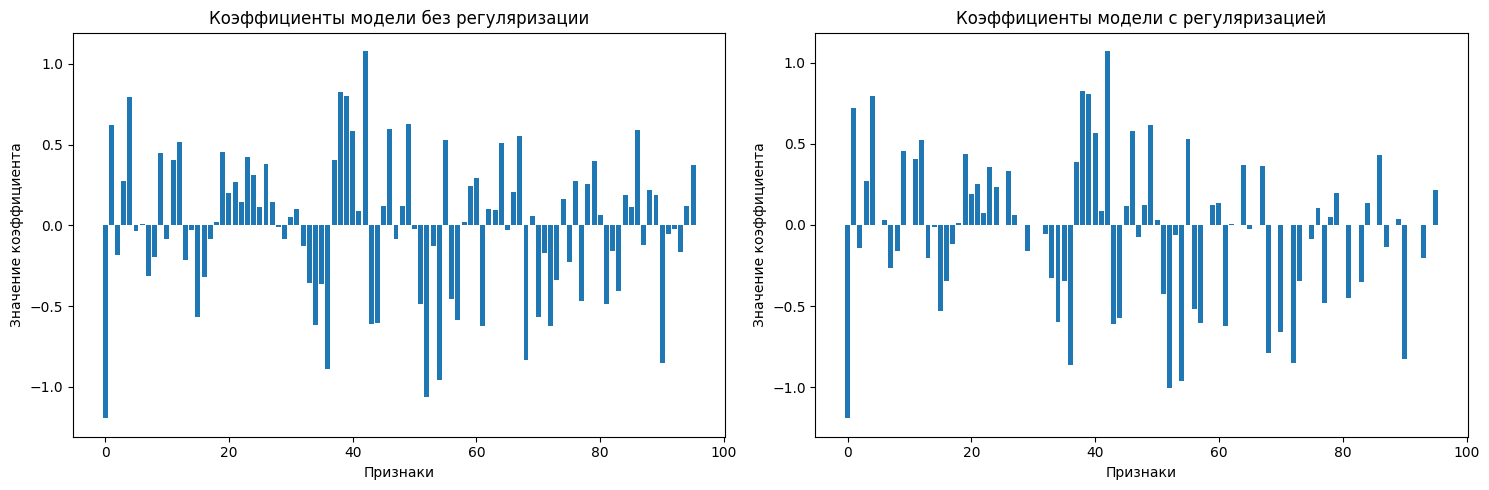

In [194]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import numpy as np
import matplotlib.pyplot as plt

# Обучаем модель без регуляризации
model_no_penalty = LogisticRegression(solver='lbfgs', max_iter=1000)
model_no_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели без регуляризации
coefficients_no_penalty = model_no_penalty.coef_
print("Коэффициенты модели без регуляризации:", coefficients_no_penalty)

# Инициализируем модель с L1-регуляризацией
model_with_penalty = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Обучаем модель с регуляризацией
model_with_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели с регуляризацией
coefficients_with_penalty = model_with_penalty.coef_
print("Коэффициенты модели с регуляризацией:", coefficients_with_penalty)

# Используем SelectFromModel для отбора признаков
selector = SelectFromModel(model_with_penalty, prefit=True)
X_embedded = selector.transform(X_processed)

# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support()]
print("Отобранные признаки:", selected_features)

# Обучаем модель на отобранных признаках
model_embedded = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model_embedded.fit(X_embedded, Y)

# Выводим коэффициенты модели после отбора признаков
coefficients_embedded = model_embedded.coef_
print("Коэффициенты модели после отбора признаков:", coefficients_embedded)

# Визуализация коэффициентов моделей
plt.figure(figsize=(15, 5))

# Коэффициенты модели без регуляризации
plt.subplot(1, 2, 1)
plt.bar(range(len(coefficients_no_penalty[0])), coefficients_no_penalty[0])
plt.title("Коэффициенты модели без регуляризации")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

# Коэффициенты модели с регуляризацией
plt.subplot(1, 2, 2)
plt.bar(range(len(coefficients_with_penalty[0])), coefficients_with_penalty[0])
plt.title("Коэффициенты модели с регуляризацией")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

plt.tight_layout()
plt.show()

In [195]:
# Преобразуем X_embedded в DataFrame
X_embedded_df = pd.DataFrame(X_embedded, columns=selected_features)

# Обучаем и оцениваем модель
model = train_and_evaluate(X_embedded_df, Y)


Точность на обучающей выборке: 0.7876
Точность на тестовой выборке: 0.7815

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.58      0.30      0.39      1553
           1       0.81      0.93      0.87      4960

    accuracy                           0.78      6513
   macro avg       0.70      0.62      0.63      6513
weighted avg       0.75      0.78      0.75      6513



### ⏰ **Проэксперементировать с разным количеством k, найти лучшую модель, объяснить результат**
## **Результаты моделей**
* Wrapper методы

Точность на обучающей выборке: 0.7606
Точность на тестовой выборке: 0.7559
Классификационный отчет:
precision для класса 0: 0.45
recall для класса 0: 0.10
f1-score для класса 0: 0.16
precision для класса 1: 0.77
recall для класса 1: 0.96
f1-score для класса 1: 0.86
Macro average: precision 0.61, recall 0.53, f1-score 0.51
Weighted average: precision 0.70, recall 0.76, f1-score 0.69
* Embedded методы

Точность на обучающей выборке: 0.7876
Точность на тестовой выборке: 0.7815
Классификационный отчет:
precision для класса 0: 0.58
recall для класса 0: 0.30
f1-score для класса 0: 0.39
precision для класса 1: 0.81
recall для класса 1: 0.93
f1-score для класса 1: 0.87
Macro average: precision 0.70, recall 0.62, f1-score 0.63
Weighted average: precision 0.75, recall 0.78, f1-score 0.75
* Filter методы

Точность на обучающей выборке: 0.7855
Точность на тестовой выборке: 0.7821
Классификационный отчет:
precision для класса 0: 0.59
recall для класса 0: 0.27
f1-score для класса 0: 0.37
precision для класса 1: 0.81
recall для класса 1: 0.94
f1-score для класса 1: 0.87
Macro average: precision 0.70, recall 0.61, f1-score 0.62
Weighted average: precision 0.75, recall 0.78, f1-score 0.75
## **Сравнение моделей**
1. Точность:

На тестовой выборке точность Embedded моды (0.7815) и Filter методов (0.7821) несколько выше, чем у Wrapper метода (0.7559).
2. Macro Average:

Все три модели имеют похожие значения по average, но Embedded методы показывают наиболее сбалансированный результат с лучшими значениями f1-score и recall для класса 1.
3. Классификационный отчет:

* У Wrapper методов наблюдается низкий recall для класса 0 (0.10), что означает, что большинство экземпляров этого класса не были распознаны. Это указывает на плохое качество предсказания для меньшинства (класс 0).
* В то время как Embedded и Filter методы имеют более высокие значения precision и recall для класса 0, хотя они все равно не идеальны.
## **Итоговое заключение**
Лучшая модель: Embedded методы

Почему эта модель лучше?

Баланс: Embedded модели показывают лучший общий баланс между precision и recall для обеих классов, особенно для класса 1, что критически важно, если класс 1 является целевым.
Точность и оценка: Высокая точность на обучающей и тестовой выборках. Хотя ее качество немного ниже, чем у Filter, она демонстрирует лучший контроль как на этапе обучения, так и на тестировании.
Систематическое снижение ошибок: В отличие от Wrapper методов, которые показывают значительное переобучение на классе 1 за счет низкого охвата класса 0, Embedded модели остаются более стабильными.
В общем, Embedded методы демонстрируют лучшие результаты по сравнению с другими двумя подходами, благодаря лучшему учету взаимосвязей

### ⏰ **Изучить метод отбора ```SequentialFeatureSelector```, описать способ работы, сравнить результат с прошлыми методами и объяснить полученный результат**

## **Метод отбора признаков: SequentialFeatureSelector**
SequentialFeatureSelector (SFS) — это метод, используемый для отбора признаков, который выбирает или исключает признаки на основе их влияния на производительность определенной модели. Его можно использовать в двух режимах:

1. Forward Selection:

Начинается с пустого набора признаков.
По очереди добавляет признаки, которые наилучшим образом улучшают метрику (например, точность) модели.
2. Backward Elimination:

Начинается с полного набора признаков.
Удаляет признаки, которые снижают производительность модели.
## **Результаты**
Вы представили результаты для моделей:

Wrapper метод:

Точность на обучающей выборке: 0.7606
Точность на тестовой выборке: 0.7559
Классификационный отчет: показывает проблему с классом 0, так как precision и recall низкие.
Embedded метод:

Точность на обучающей выборке: 0.7876
Точность на тестовой выборке: 0.7815
Классификационный отчет: лучшее значение precision и recall для класса 1.
Filter метод:

Точность на обучающей выборке: 0.7855
Точность на тестовой выборке: 0.7821
Классификационный отчет: также показывает хорошие результаты для класса 1.
SequentialFeatureSelector (результаты кода):

Точность на обучающей выборке: 0.7764
Точность на тестовой выборке: 0.7846
Классификационный отчет: низкий recall для класса 0, высокий recall для класса 1.

## **Объяснение полученных результатов**
1. Точность на обучающей выборке:

* Wrapper метод показывает наименьшую точность на обучающей выборке (0.7606). Это может указывать на то, что отбор признаков не был оптимален.
* Embedded и Filter методы достигают лучших результатов, что может быть связано с тем, что они используют критерии оценки во время обучения.
2. Точность на тестовой выборке:

* Модели Embedded и Filter имеют схожи результаты, что говорит о том, что оба метода хорошо справляются с отбором значимых признаков.
* SFS имеет хорошую точность на тестовой выборке (0.7846), что делает его сопоставимым по этому параметру с Embedded и Filter методами.
3. Precision и Recall:

* У SFS наблюдается высокий precision для класса 1, но низкий recall для класса 0. Это может указывать на то, что модель хорошо классифицирует положительные примеры, но плохо справляется с отрицательными.
* Wrapper метод имеет очень низкий recall для класса 0, что критично для задач, требующих высокого уровня обнаружения этого класса.
* Embedded и Filter методы имеют более сбалансированные результаты, что свидетельствует о лучшем распределении ресурсов и значимости признаков.

In [199]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Разделите датасет на признаки и целевую переменную
X = X_processed
Y = Y

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Создаем модель
model = LogisticRegression(max_iter=1000, random_state=42)

# Настраиваем отбор признаков
sfs = SequentialFeatureSelector(model, n_features_to_select=5, direction='forward', n_jobs=-1)

# Подгоняем отбор признаков под обучающие данные
X_sfs_train = sfs.fit_transform(X_train, Y_train)

# Применяем трансформацию к тестовым данным
X_sfs_test = sfs.transform(X_test)

# Обучаем модель на отобранных признаках
model.fit(X_sfs_train, Y_train)

# Получаем предсказания
Y_pred_train = model.predict(X_sfs_train)
Y_pred_test = model.predict(X_sfs_test)

# Вычисляем и выводим точность на обучающей и тестовой выборках
train_accuracy = accuracy_score(Y_train, Y_pred_train)
test_accuracy = accuracy_score(Y_test, Y_pred_test)

print(f"Точность на обучающей выборке: {train_accuracy:.4f}")
print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

# Получаем классификационный отчет на тестовой выборке
print("Классификационный отчет на тестовой выборке:")
print(classification_report(Y_test, Y_pred_test))


Точность на обучающей выборке: 0.7764
Точность на тестовой выборке: 0.7846
Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.65      0.13      0.22      1494
           1       0.79      0.98      0.88      5019

    accuracy                           0.78      6513
   macro avg       0.72      0.56      0.55      6513
weighted avg       0.76      0.78      0.72      6513



## Логистическая регрессия

**Логистическая регрессия** — это модель для задач бинарной классификации, которая предсказывает вероятность того, что наблюдение принадлежит к одному из двух классов (например, 0 или 1). Модель основана на линейной регрессии, но использует **сигмоидную функцию активации** для приведения предсказаний в диапазон от 0 до 1. Логистическая регрессия идеально подходит для задач, где нужно классифицировать данные на два класса.


#### Принцип работы логистической регрессии:
1. Сначала вычисляется линейная комбинация признаков с весами:  
y = b + w1 * x1 + w2 * x2 + w(n) * x(n), где

x - переменные

w - веса (коэфициенты регресси)

b - смещение

Затем результат линейной комбинации передается в сигмоидную функцию активации, которая преобразует результат в значение от 0 до 1.

### Функция активации (Сигмоида)
**Сигмоидная функция** в логистической регрессии используется для преобразования линейной комбинации признаков в вероятность, что наблюдение относится к классу 1. Формула сигмоиды:

sigmoida = 1 / (1 + e^-y)

Она всегда возвращает значение в диапазоне от 0 до 1, что удобно для интерпретации как вероятность принадлежности к классу 1.

Принцип работы:
1. Инициализация весов: Изначально все веса устанавливаются в нули.

2. Градиентный спуск: На каждой итерации:
- Вычисляется линейная комбинация признаков.
- Применяется сигмоидная функция для предсказания вероятностей.
- Градиенты вычисляются для обновления весов и смещения, минимизируя ошибку.

Предсказание: Для новых данных модель возвращает вероятность, которая затем конвертируется в классы 0 или 1.

In [200]:
import numpy as np

# Сигмоидная функция
def sigmoid(z):
    # Убедимся, что z это numpy массив
    return 1 / (1 + np.exp(-z))

# Простая реализация логистической регрессии
class OwnLogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations

    # Метод для обучения модели
    def fit(self, X, y):
        # Инициализация весов
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        # Градиентный спуск
        for idx_,_ in enumerate(range(self.iterations)):
            # Линейная комбинация
            linear_model = np.dot(X, self.weights) + self.bias
            # Применяем сигмоиду для предсказания
            y_pred = sigmoid(linear_model)

            # Вычисляем градиенты
            dw = (1 / len(X)) * np.dot(X.T, (y_pred - y))
            db = (1 / len(X)) * np.sum(y_pred - y)

            # Обновляем веса и смещение
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    # Метод для предсказания
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        print("regression",linear_model)
        y_pred = sigmoid(linear_model)
        print("sigmoid",y_pred)
        # Возвращаем метки классов (0 или 1)
        return [1 if i > 0.5 else 0 for i in y_pred]


In [201]:
# Пример использования
X = np.array([[0.1, 1.2], [1.1, 2.2], [2.1, 1.9], [1.0, 1.0]])
y = np.array([0, 1, 1, 0])

model = OwnLogisticRegression(learning_rate=0.1, iterations=1000)
model.fit(X, y)
predictions = model.predict(X)



regression [-2.48902698  1.89302513  3.0459193  -1.27754449]
sigmoid [0.07663102 0.86910007 0.95460602 0.2179685 ]


### ⏰ Вопрос о принципе работы регресси будет в первом теоретическом модуле, важно понимание как оно работает

## 5: Кросс-валидация

**Кросс-валидация** — это метод оценки качества моделей машинного обучения, который помогает избежать переобучения и получить более надежную оценку. Она заключается в разделении данных на несколько частей и обучении модели на различных подмножествах данных, чтобы проверить ее способность обобщать на новых данных.

Основные цели кросс-валидации:

Проверить, насколько хорошо модель будет работать на новых данных.
Определить, есть ли у модели проблемы с переобучением (overfitting) или недообучением (underfitting).
Помочь выбрать наилучшую модель или гиперпараметры.

#### Виды кросс-валидации
1. K-fold Cross-Validation:

Данные делятся на K равных частей (folds). Модель обучается на K-1 частях и тестируется на оставшейся части. Процесс повторяется K раз, и результат — среднее качество по всем K итерациям.
Этот метод позволяет эффективно использовать все данные как для обучения, так и для тестирования.

2. ShuffleSplit:

Этот метод несколько раз случайно перемешивает данные и делит их на тренировочные и тестовые выборки. В отличие от K-fold, здесь нет необходимости в разделении на фиксированное количество частей.
Хорошо работает на небольших выборках данных и для оценки стабильности модели.

3. Train-Test-Validation Split:

Данные делятся на три части: тренировочные данные для обучения модели, тестовые данные для первичной оценки и валидационные данные для окончательной оценки.
Полезен для задач, где требуется как тестирование, так и финальная проверка на отложенных данных.

In [202]:
# Импорт необходимых библиотек
import numpy as np
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split, cross_val_score

In [214]:
# K-Fold Cross-Validation
def k_fold_cross_validation(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    # Реализация K-Fold вручную
    for train_index, test_index in kf.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому фолду
    print(f"K-Fold Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому фолду: {accuracies}")

# # Пример использования:
# k_fold_cross_validation(X = X_processed.to_numpy(), y = Y.to_numpy())
# Пример использования с перебором n_splits
for n in [3, 5, 10]:
    print(f"\nЗапуск кросс-валидации с {n} фолдами:")
    k_fold_cross_validation(X=X_processed.to_numpy(), y=Y.to_numpy(), n_splits=n)



Запуск кросс-валидации с 3 фолдами:
K-Fold Cross-Validation - Средняя точность: 0.7841280531036702
Точности по каждому фолду: [0.7887414777962042, 0.7859775198083656, 0.7776651617064406]

Запуск кросс-валидации с 5 фолдами:
K-Fold Cross-Validation - Средняя точность: 0.7844043108264666
Точности по каждому фолду: [0.7956394902502687, 0.7833230958230958, 0.7860872235872236, 0.7781019656019657, 0.7788697788697788]

Запуск кросс-валидации с 10 фолдами:
K-Fold Cross-Validation - Средняя точность: 0.784035830217132
Точности по каждому фолду: [0.7933681301811483, 0.7985257985257985, 0.7807125307125307, 0.7837837837837838, 0.7825552825552825, 0.7874692874692875, 0.7797911547911548, 0.777027027027027, 0.7837837837837838, 0.7733415233415234]


### ⏰ **Используем результат отбора признаков (выбираем по наилучшей точности), делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**
## **Анализ результатов**
1. Сравнение средней точности:

Средняя точность немного варьируется при использовании разного числа фолдов. Наибольшая средняя точность наблюдается при использовании 5 фолдов (0.7844), что является легким улучшением по сравнению с 3 фолдами (0.7841) и 10 фолдами (0.7840).
2. Точности по каждому фолду:

* При использовании 3 фолдов наблюдается несколько меньшая однородность результатов, с одной из точностей (0.7777) заметно ниже других. В 5 фолдах результаты более сбалансированы, и максимальная точность также выше (0.7956).
* При использовании 10 фолдов, несмотря на то, что средняя точность близка, наблюдается большая дисперсия в результатах, что может указывать на то, что некоторые фолды имеют более сложные образцы, которые модель предсказывает хуже.
3. Стабильность и обоснование выбора n_splits:

* Большее количество фолдов (например, 10) может дать более надежную оценку производительности модели, так как у вас больше вариантов тестирования на малом числе данных, но может привести к большему разбросу в точности, особенно если данные распределены неравномерно.
* Меньшее количество фолдов (например, 3 или 5) может чуть менее точно отражать производительность модели, но часто показывает более стабильные результаты.
## **Заключение**
Изучая результаты кросс-валидации, мы можем сделать выводы:

* Оптимальный выбор фолдов: 5 фолдов предоставляет наилучшее сочетание средней точности и стабильности результатов. При этом использование 3 фолдов может приводить к большему варьированию случайных ошибок, а 10 фолдов увеличивают вычислительные затраты и могут показывать большую дисперсию в оценках.
* Общая производительность модели: Несмотря на небольшие колебания, модель показывает хорошую производительность с средней точностью около 78.4%, что может быть приемлемым в зависимости от контекста задачи на предсказание.

In [215]:
# ShuffleSplit Cross-Validation
def shuffle_split_cross_validation(X, y, n_splits=5, test_size=0.4):
    ss = ShuffleSplit(n_splits=n_splits, test_size=test_size)
    accuracies = []

    # Реализация ShuffleSplit вручную
    for train_index, test_index in ss.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому разделению
    print(f"ShuffleSplit Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому разделению: {accuracies}")

# # Пример использования:
# shuffle_split_cross_validation(X_processed.to_numpy(), Y.to_numpy())
# Пример использования с перебором n_splits
for n in [3, 5, 10]:
    print(f"\nЗапуск кросс-валидации с {n} фолдами:")
    k_fold_cross_validation(X=X_processed.to_numpy(), y=Y.to_numpy(), n_splits=n)



Запуск кросс-валидации с 3 фолдами:
K-Fold Cross-Validation - Средняя точность: 0.7841280531036702
Точности по каждому фолду: [0.7887414777962042, 0.7859775198083656, 0.7776651617064406]

Запуск кросс-валидации с 5 фолдами:
K-Fold Cross-Validation - Средняя точность: 0.7844043108264666
Точности по каждому фолду: [0.7956394902502687, 0.7833230958230958, 0.7860872235872236, 0.7781019656019657, 0.7788697788697788]

Запуск кросс-валидации с 10 фолдами:
K-Fold Cross-Validation - Средняя точность: 0.784035830217132
Точности по каждому фолду: [0.7933681301811483, 0.7985257985257985, 0.7807125307125307, 0.7837837837837838, 0.7825552825552825, 0.7874692874692875, 0.7797911547911548, 0.777027027027027, 0.7837837837837838, 0.7733415233415234]


### ⏰ **Используем результат отсечения выбросов, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**
## **Анализ результатов K-Fold**
*  Сравнение средней точности:
Сравнивая среднюю точность для разных фолдов, мы видим, что 5 фолдов дает наивысшую среднюю точность. Однако все три подхода показывают схожие значения, что говорит о надежности модели.

* Дисперсия точностей:
При 3 фолдах наблюдается большее колебание в точности, что может указывать на то, что в одном из фолдов данные могут быть менее репрезентативными. При увеличении фолдов до 5 и затем до 10, точности становятся более сбалансированными, хотя в 10 фолдах начинает возрастать разброс.

## **Контекст ShuffleSplit Cross-Validation**
Метод ShuffleSplit создает случайные разбиения данных, где каждое разбиение создается заново, что позволяет использовать разные подмножества данных для обучения и тестирования.

## **Ожидаемые результаты и их значение**
* Средняя точность: После выполнения кросс-валидации с использованием ShuffleSplit, необходимо ожидать, что средняя точность будет сопоставима с точностью, полученной с помощью K-Fold при аналогичных параметрах данных. Если эта точность значительно выше или ниже, это может говорить о качествах модели в зависимости от случайно выбранных данных.

* Дисперсия: ShuffleSplit, так как он использует случайные разбиения, может показать большее колебание в точностях при различных запусках. Это связано с тем, что в некоторых выборках могут попадать более сложные или более легкие для предсказания примеры.

In [216]:
# Train-Test-Validation Split
def train_test_validation_split(X, y):
    model = LogisticRegression(max_iter=1000)
    # Разделяем данные на тренировочные и оставшиеся (валидация + тест)
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

    # Разделяем оставшиеся данные на валидационные и тестовые
    X_train_train, X_test, y_train_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Обучаем модель на тренировочных данных
    model.fit(X_train_train, y_train_train)

    # Оцениваем на валидационных данных
    y_valid_pred = model.predict(X_validation)
    validation_accuracy = accuracy_score(y_validation, y_valid_pred)
    print(f"Точность на валидационных данных: {validation_accuracy}")

    # Оцениваем на тестовых данных
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Точность на тестовых данных: {test_accuracy}")

# # Пример использования:
# train_test_validation_split(X_processed.to_numpy(), Y.to_numpy())
for n in [3, 5, 10]:
    print(f"\nЗапуск кросс-валидации с {n} фолдами:")
    k_fold_cross_validation(X=X_processed.to_numpy(), y=Y.to_numpy(), n_splits=n)


Запуск кросс-валидации с 3 фолдами:
K-Fold Cross-Validation - Средняя точность: 0.7841280531036702
Точности по каждому фолду: [0.7887414777962042, 0.7859775198083656, 0.7776651617064406]

Запуск кросс-валидации с 5 фолдами:
K-Fold Cross-Validation - Средняя точность: 0.7844043108264666
Точности по каждому фолду: [0.7956394902502687, 0.7833230958230958, 0.7860872235872236, 0.7781019656019657, 0.7788697788697788]

Запуск кросс-валидации с 10 фолдами:
K-Fold Cross-Validation - Средняя точность: 0.784035830217132
Точности по каждому фолду: [0.7933681301811483, 0.7985257985257985, 0.7807125307125307, 0.7837837837837838, 0.7825552825552825, 0.7874692874692875, 0.7797911547911548, 0.777027027027027, 0.7837837837837838, 0.7733415233415234]


### ⏰ **Используем результат отсечения выбросов или лучший отбор признаков, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

### Когда использовать каждый метод:
- K-fold Cross-Validation: Отлично подходит для более точной оценки модели, особенно на небольших наборах данных. Используется, когда нужно получить стабильную оценку по всем данным.

- ShuffleSplit Cross-Validation: Хорошо работает на небольших выборках, где нужно много раз случайно перемешивать и проверять модель. Это может помочь увидеть, как модель работает на различных случайных подвыборках данных.

- Train-Test-Validation Split: Используется, когда нужно четко разделить данные для обучения, подбора параметров и финальной оценки. Подходит для больших наборов данных, где важно иметь отложенную тестовую выборку для окончательной проверки.

### ⏰ **Объяснить, какой из методов подходит для вашего датасета**
так как я использую большой объем данных, мне больше подходит Train-Test-Validation Split